In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Load and preprocess PlantVillage
plant_village = tfds.load("plant_village", split="train", shuffle_files=True)
plant_village = plant_village.map(lambda x: (x['image'], x['label']), num_parallel_calls=tf.data.AUTOTUNE)
plant_village = plant_village.map(preprocess).take(2000)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


# Load and preprocess plant_leaves dataset (limit to ~2000 images to save RAM)
indian_leaves = tfds.load("plant_leaves", split="train", shuffle_files=True)
indian_leaves = indian_leaves.map(lambda x: (x['image'], x['label']), num_parallel_calls=tf.data.AUTOTUNE)
indian_leaves = indian_leaves.map(preprocess).take(2000)


In [ ]:
# Load and preprocess LFW dataset (limit to 600 images)
lfw = tfds.load("lfw", split="train", shuffle_files=True)
lfw = lfw.map(lambda x: (x['image'], tf.constant(60)), num_parallel_calls=tf.data.AUTOTUNE)
lfw = lfw.map(preprocess).take(600)

In [ ]:
# Load CIFAR-10 dataset
cifar10_animals = tfds.load("cifar10", split="train", shuffle_files=True)

# Animal label IDs in CIFAR-10 (int64 to match TFDS labels)
animal_labels = tf.constant([2, 3, 4, 5, 6, 7], dtype=tf.int64)

# Filter to keep only animals
cifar10_animals = cifar10_animals.filter(lambda x: tf.reduce_any(tf.equal(animal_labels, x['label'])))

# Map all animal images to class 60 (non-plant)
cifar10_animals = cifar10_animals.map(lambda x: (x['image'], tf.constant(60)), num_parallel_calls=tf.data.AUTOTUNE)

# Preprocess and limit to 600
cifar10_animals = cifar10_animals.map(preprocess).take(600)

In [ ]:
# Load CIFAR-100 dataset
cifar100_objects = tfds.load("cifar100", split="train", shuffle_files=True)

# Map all material object images to class 60 (non-plant)
cifar100_objects = cifar100_objects.map(lambda x: (x['image'], tf.constant(60)), num_parallel_calls=tf.data.AUTOTUNE)

# Preprocess and limit to 600
cifar100_objects = cifar100_objects.map(preprocess).take(600)

In [ ]:
def ensure_int64_label(img, label):
    return img, tf.cast(label, tf.int64)

# Apply to all datasets
plant_village = plant_village.map(ensure_int64_label)
indian_leaves = indian_leaves.map(ensure_int64_label)
lfw = lfw.map(ensure_int64_label)
cifar10_animals = cifar10_animals.map(ensure_int64_label)
cifar100_objects = cifar100_objects.map(ensure_int64_label)

# Now combine
full_ds = plant_village \
    .concatenate(indian_leaves) \
    .concatenate(lfw) \
    .concatenate(cifar10_animals) \
    .concatenate(cifar100_objects)

# Shuffle, batch, prefetch
full_ds = full_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
sample_count = sum(1 for _ in full_ds.unbatch())
print("Total samples in full dataset:", sample_count)

Total samples in full dataset: 5800


In [ ]:
# Split into 80% train, 20% val
train_size = int(0.8 * sample_count)
val_size = sample_count - train_size

# Unbatch, split, then batch again
full_unbatched = full_ds.unbatch()
train_dataset = full_unbatched.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = full_unbatched.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify sizes
train_count = sum(1 for _ in train_dataset.unbatch())
val_count = sum(1 for _ in val_dataset.unbatch())

print("Train set size:", train_count)
print("Validation set size:", val_count)

Train set size: 4640
Validation set size: 1160


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(61, activation='softmax')  # 60 plant + non-plant
])

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 61)             │         7,869 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,509 (12.64 MB)

 Trainable params: 3,312,509 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import time
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from google.colab import drive

# 1️⃣ Mount Google Drive to store checkpoints permanently
drive.mount('/content/drive')
checkpoint_dir = "/content/drive/MyDrive/plant_model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 2️⃣ Time tracking callback (optional)
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.epoch_times.append(epoch_time)
        avg_time = sum(self.epoch_times) / len(self.epoch_times)
        remaining_epochs = self.params['epochs'] - (epoch + 1)
        eta = remaining_epochs * avg_time
        print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s — ETA: {eta/60:.1f} min")

time_callback = TimeHistory()

# 3️⃣ Checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    save_freq="epoch",
    verbose=1
)

# 4️⃣ Find latest checkpoint and resume from it
latest_ckpt = sorted(
    [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".h5")]
)

initial_epoch = 0
if latest_ckpt:
    last_ckpt = latest_ckpt[-1]
    print(f"🔄 Resuming from checkpoint: {last_ckpt}")
    model.load_weights(last_ckpt)
    try:
        initial_epoch = int(last_ckpt.split("_epoch_")[1].split(".")[0])
    except:
        initial_epoch = 0
else:
    print("🚀 No checkpoint found, starting fresh.")

print(f"➡ Starting training from epoch: {initial_epoch + 1}")

# 5️⃣ Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,              # total epochs you want from scratch
    initial_epoch=initial_epoch,
    callbacks=[checkpoint_cb, time_callback]
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Resuming from checkpoint: /content/drive/MyDrive/plant_model_checkpoints/model_epoch_09.weights.h5
➡ Starting training from epoch: 10
Epoch 10/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


    145/Unknown 384s 1s/step - accuracy: 0.7232 - loss: 0.9700

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: saving model to /content/drive/MyDrive/plant_model_checkpoints/model_epoch_10.weights.h5
Epoch 10 completed in 627.0s — ETA: 104.5 min
145/145 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.7232 - loss: 0.9696 - val_accuracy: 0.8612 - val_loss: 0.4760
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7626 - loss: 0.7781
Epoch 11: saving model to /content/drive/MyDrive/plant_model_checkpoints/model_epoch_11.weights.h5
Epoch 11 completed in 620.2s — ETA: 93.5 min
145/145 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.7625 - loss: 0.7783 - val_accuracy: 0.8060 - val_loss: 0.6324
Epoch 12/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7348 - loss: 0.8579
Epoch 12: saving model to /content/drive/MyDrive/plant_model_checkpoints/model_epoch_12.weights.h5
Epoch 12 completed in 609.8s — ETA: 82.5 min
145/145 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.7349 - loss: 0.8576 - val_accuracy: 0.9078 - val_loss: 0.3498
Epoch 13/20
145/145 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate on validation or test dataset
loss, acc = model.evaluate(val_dataset)
print(f"📊 Validation Accuracy: {acc*100:.2f}%")
print(f"📉 Validation Loss: {loss:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 249ms/step - accuracy: 0.9475 - loss: 0.2019
📊 Validation Accuracy: 95.52%
📉 Validation Loss: 0.1787


In [ ]:
from google.colab import files
import shutil

# ✅ Save in new Keras format (recommended)
model.save("/content/final_model.keras")
print("✅ Model saved in Keras format at final_model.keras")

# ✅ Also save in HDF5 format for compatibility
model.save("/content/final_model.h5")
print("✅ Model saved as final_model.h5 (legacy format)")

# ✅ Export TensorFlow SavedModel format
model.export("/content/final_model_savedmodel")
print("✅ Model exported in TensorFlow SavedModel format")

# Download the .keras file
files.download("/content/final_model.keras")

# (Optional) Zip SavedModel before downloading
shutil.make_archive("/content/final_model_savedmodel", 'zip', "/content/final_model_savedmodel")
files.download("/content/final_model_savedmodel.zip")

✅ Model saved in Keras format at final_model.keras
✅ Model saved as final_model.h5 (legacy format)
Saved artifact at '/content/final_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 61), dtype=tf.float32, name=None)
Captures:
  139165555036560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555036176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555038096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555037136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555039824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555037328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555038480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555039632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139165555040208: TensorSpec(shape=(), d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download HDF5 model
files.download("/content/final_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow_datasets as tfds

# Indian Leaves dataset info
indian_leaves_builder = tfds.builder("plant_leaves")
indian_leaves_info = indian_leaves_builder.info
print("Indian Leaves classes:")
print(indian_leaves_info.features['label'].names)

# PlantVillage dataset info
plantvillage_builder = tfds.builder("plant_village")
plantvillage_info = plantvillage_builder.info
print("\nPlantVillage classes:")
print(plantvillage_info.features['label'].names)

# CIFAR-10 dataset info
cifar10_builder = tfds.builder("cifar10")
cifar10_info = cifar10_builder.info
print("\nCIFAR-10 classes:")
print(cifar10_info.features['label'].names)

# CIFAR-100 dataset info
cifar100_builder = tfds.builder("cifar100")
cifar100_info = cifar100_builder.info
print("\nCIFAR-100 classes:")
print(cifar100_info.features['label'].names)

Indian Leaves classes:
['Mango (P0) healthy', 'Arjun (P1) healthy', 'Alstonia Scholaris (P2) healthy', 'Gauva (P3) healthy', 'Jamun (P5) healthy', 'Jatropha (P6) healthy', 'Pongamia Pinnata (P7) healthy', 'Basil (P8) healthy', 'Pomegranate (P9) healthy', 'Lemon (P10) healthy', 'Chinar (P11) healthy', 'Mango (P0) diseased', 'Arjun (P1) diseased', 'Alstonia Scholaris (P2) diseased', 'Gauva (P3) diseased', 'Bael (P4) diseased', 'Jamun (P5) diseased', 'Jatropha (P6) diseased', 'Pongamia Pinnata (P7) diseased', 'Pomegranate (P9) diseased', 'Lemon (P10) diseased', 'Chinar (P11) diseased']

PlantVillage classes:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf

In [ ]:
num_classes = model.output_shape[-1]
print("Model number of classes:", num_classes)
print("Length of class_names:", len(class_names))

Model number of classes: 61
Length of class_names: 32


In [ ]:
print("Predicted classes:", pred_classes)
print("True labels:", [labels[i].numpy() for i in range(len(labels))])

Predicted classes: [60 60 19 37  6 60  1  6 60 15 60 13 60 60  3 60  8 19  6  6 60  6 19 26
  8 60 60 60 30 37 60 60]
True labels: [np.int64(60), np.int64(60), np.int64(19), np.int64(37), np.int64(6), np.int64(60), np.int64(12), np.int64(6), np.int64(60), np.int64(15), np.int64(60), np.int64(13), np.int64(60), np.int64(60), np.int64(3), np.int64(60), np.int64(8), np.int64(19), np.int64(6), np.int64(6), np.int64(60), np.int64(6), np.int64(1), np.int64(26), np.int64(8), np.int64(60), np.int64(60), np.int64(60), np.int64(30), np.int64(37), np.int64(60), np.int64(60)]


In [ ]:
print("Model output classes:", model.output_shape[-1])

Model output classes: 61


Total classes: 61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


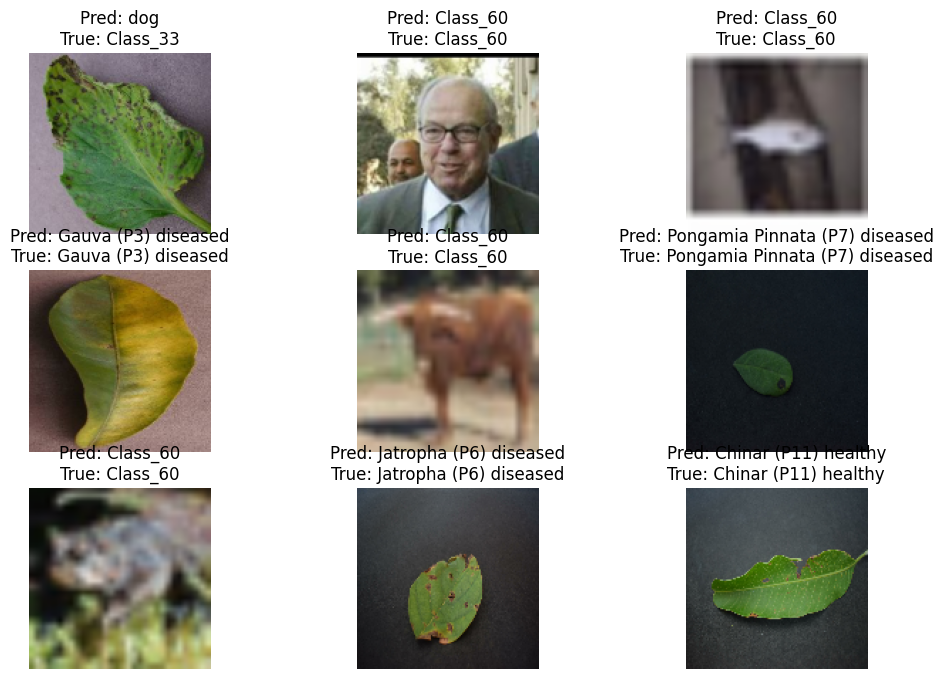

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your class names list (make sure it matches your model's classes)
class_names = [
    # Indian plants - healthy (12)
    'Mango (P0) healthy', 'Arjun (P1) healthy', 'Alstonia Scholaris (P2) healthy',
    'Gauva (P3) healthy', 'Bael (P4) healthy', 'Jamun (P5) healthy', 'Jatropha (P6) healthy',
    'Pongamia Pinnata (P7) healthy', 'Basil (P8) healthy', 'Pomegranate (P9) healthy',
    'Lemon (P10) healthy', 'Chinar (P11) healthy',

    # Indian plants - diseased (11)
    'Mango (P0) diseased', 'Arjun (P1) diseased', 'Alstonia Scholaris (P2) diseased',
    'Gauva (P3) diseased', 'Bael (P4) diseased', 'Jamun (P5) diseased',
    'Jatropha (P6) diseased', 'Pongamia Pinnata (P7) diseased',
    'Pomegranate (P9) diseased', 'Lemon (P10) diseased', 'Chinar (P11) diseased',

    # CIFAR-10 classes (10)
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck',
]

# Fill remaining classes to reach 61
for i in range(len(class_names), 61):
    class_names.append(f"Class_{i}")

print(f"Total classes: {len(class_names)}")  # Should print 61

# Visualize predictions for one batch from validation dataset
for images, labels in val_dataset.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)

        # Fix for image display (handle normalization and grayscale)
        img = images[i].numpy()
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        else:
            img = img.astype("uint8")

        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)

        plt.axis("off")

        pred_idx = pred_classes[i]
        true_idx = labels[i].numpy()

        pred_label = class_names[pred_idx] if pred_idx < len(class_names) else f"Unknown({pred_idx})"
        true_label = class_names[true_idx] if true_idx < len(class_names) else f"Unknown({true_idx})"

        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")

    plt.show()

In [ ]:
# 1. Define your datasets class lists:

plant_village_classes = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust',
    'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew',
    'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy',
    'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
    'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight',
    'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
    'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot',
    'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

indian_leaves_classes = [
    'Mango (P0) healthy', 'Arjun (P1) healthy', 'Alstonia Scholaris (P2) healthy',
    'Gauva (P3) healthy', 'Jamun (P5) healthy', 'Jatropha (P6) healthy',
    'Pongamia Pinnata (P7) healthy', 'Basil (P8) healthy', 'Pomegranate (P9) healthy',
    'Lemon (P10) healthy', 'Chinar (P11) healthy', 'Mango (P0) diseased',
    'Arjun (P1) diseased', 'Alstonia Scholaris (P2) diseased', 'Gauva (P3) diseased',
    'Bael (P4) diseased', 'Jamun (P5) diseased', 'Jatropha (P6) diseased',
    'Pongamia Pinnata (P7) diseased', 'Pomegranate (P9) diseased',
    'Lemon (P10) diseased', 'Chinar (P11) diseased'
]


lfw_class_count = 5749  # total classes in LFW dataset approx.

# Create LFW classes all labeled as "human"
lfw_classes = ["human"] * lfw_class_count

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifar100_class_count = 100  # total CIFAR-100 classes

# Create CIFAR-100 classes all labeled as "not plant"
cifar100_classes = ["not plant"] * cifar100_class_count

# 2. Merge all classes in order:
class_names = plant_village_classes + indian_leaves_classes + lfw_classes + cifar10_classes + cifar100_classes

print(f"Total classes in combined list: {len(class_names)}")


Total classes in combined list: 5919


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Replace this with your actual image file path
image_path = "/content/Arijit_pic.jpg"

# Load and preprocess the image to match your model's input size & format
def load_and_preprocess_image(img_path, img_size=(128, 128)):
    img = Image.open(img_path).convert('RGB')  # convert to RGB
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0          # normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # add batch dim
    return img_array

# Load your saved model (if not loaded)
# model = tf.keras.models.load_model("final_model.keras")

# Preprocess your image
img_input = load_and_preprocess_image(image_path)

# Predict
pred = model.predict(img_input)
pred_class_idx = np.argmax(pred, axis=1)[0]

# Get predicted class name (make sure class_names list matches model)
pred_class_name = class_names[pred_class_idx]

print(f"Predicted class: {pred_class_name} (index {pred_class_idx})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class: human (index 60)
